# **Construcción de modelo Extra Trees Classifier**

# **Importación de librerías necesarias** 

In [1]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint as sp_randint

# **Carga de los datos**

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X_train = train.drop('class', axis=1)
y_train = train['class'].copy()
X_test = test.drop('class', axis=1)
y_test = test['class'].copy()

# **Optimización de hiperparámetros** 

## **Inicialización del modelo ExtraTreesClassifier**

In [3]:
rf = GradientBoostingClassifier(n_estimators=100)

## **Configuración del entorno de la búsqueda**

In [4]:
# Definiendo los dominios de los hiperparámetros
param_dist = {"loss": ["log_loss", "exponential"],
              "learning_rate" : sp_randint(1, 10),
              "criterion": ["friedman_mse", "squared_error"],
              "max_depth": [3, 9, None],
              "max_features": sp_randint(1, 11),
              }

In [5]:
# Numeros de muestras del espacio de hiperparametros a generar
samples = 50
randomCV = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=samples,cv=3)

## **Búsqueda aleatoria de hiperparámetros**

In [6]:
randomCV.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=50,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000000000D697B10>,
                                        'loss': ['log_loss', 'exponential'],
                                        'max_depth': [3, 9, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000000000D697FD0>})

In [7]:
#Mostrando los mejores parametros obtenidos
print(randomCV.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'exponential', 'max_depth': 9, 'max_features': 10}


In [8]:
randomCV.cv_results_['mean_test_score']

array([0.56430558, 0.849678  , 0.66484161, 0.8561155 , 0.79276829,
       0.65415689, 0.6400521 , 0.66066048, 0.87412658, 0.82255851,
       0.88460453, 0.86008746, 0.8575535 , 0.59738633, 0.81927128,
       0.68477197, 0.8932335 , 0.5860183 , 0.46541706, 0.82666687,
       0.8895356 , 0.78769994, 0.68922151, 0.81858665, 0.79009691,
       0.83837845, 0.89076834, 0.87186652, 0.67696232, 0.60053649,
       0.61402669, 0.84050099, 0.6212142 , 0.86762031, 0.48719013,
       0.83248816, 0.82221616, 0.68100231, 0.8380363 , 0.5219114 ,
       0.56971484, 0.84652742, 0.8427602 , 0.60252492, 0.4696018 ,
       0.81139546, 0.54917214, 0.84098067, 0.83420034, 0.75866435])

In [9]:
randomCV.score(X_test,y_test)

0.8890197926484449

# **Creación del modelo obtenido**

In [10]:
# Parametros obtenidos en la busqueda
params = randomCV.best_params_

In [11]:
randomCV.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 1,
 'loss': 'exponential',
 'max_depth': 9,
 'max_features': 10}

## **Inicialización del modelo**

In [12]:
rf = GradientBoostingClassifier(n_estimators=100, **randomCV.best_params_)

In [13]:
rf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, loss='exponential', max_depth=9,
                           max_features=10)

## **Predicción del modelo**

In [14]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# **Métricas del modelo** 

In [15]:
rf.score(X_test,y_test)

0.8932610744580585

In [16]:
# Accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.8932610744580585

In [17]:
# Matthew Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_test_pred)

0.7872855089587975

In [18]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[2025,  164],
       [ 289, 1766]], dtype=int64)

In [19]:
# Reporte de clasificación
from sklearn.metrics import classification_report

model_report = classification_report(y_test, y_test_pred, target_names=['positive','negative'])

f = open('xgb_model_report.txt','w')
f.writelines(model_report) 
f.close()

In [20]:
# Devolver la importancia de los features del modelo
importance = pd.Series(rf.feature_importances_, name = 'Gini')

# Devolver los nombre de los features
feature_names = pd.Series(X_train.columns, name = 'Feature')

In [21]:
# Combinar los nombre de los nombres de los features y los valores de Gini en un Dataframe
df = pd.concat([feature_names, importance], axis=1, names=['Feature', 'Gini'])
df

,Feature,Gini
0,AAC_A,0.004855
1,AAC_C,0.008236
2,AAC_D,0.017223
3,AAC_E,0.099595
4,AAC_F,0.006096
...,...,...
108,QSO1_SC_A,0.005855
109,QSO1_SC_K,0.017384
110,QSO1_SC_L,0.008321
111,QSO1_SC_R,0.007233


Text(0.5, 0, 'Feature Importance')

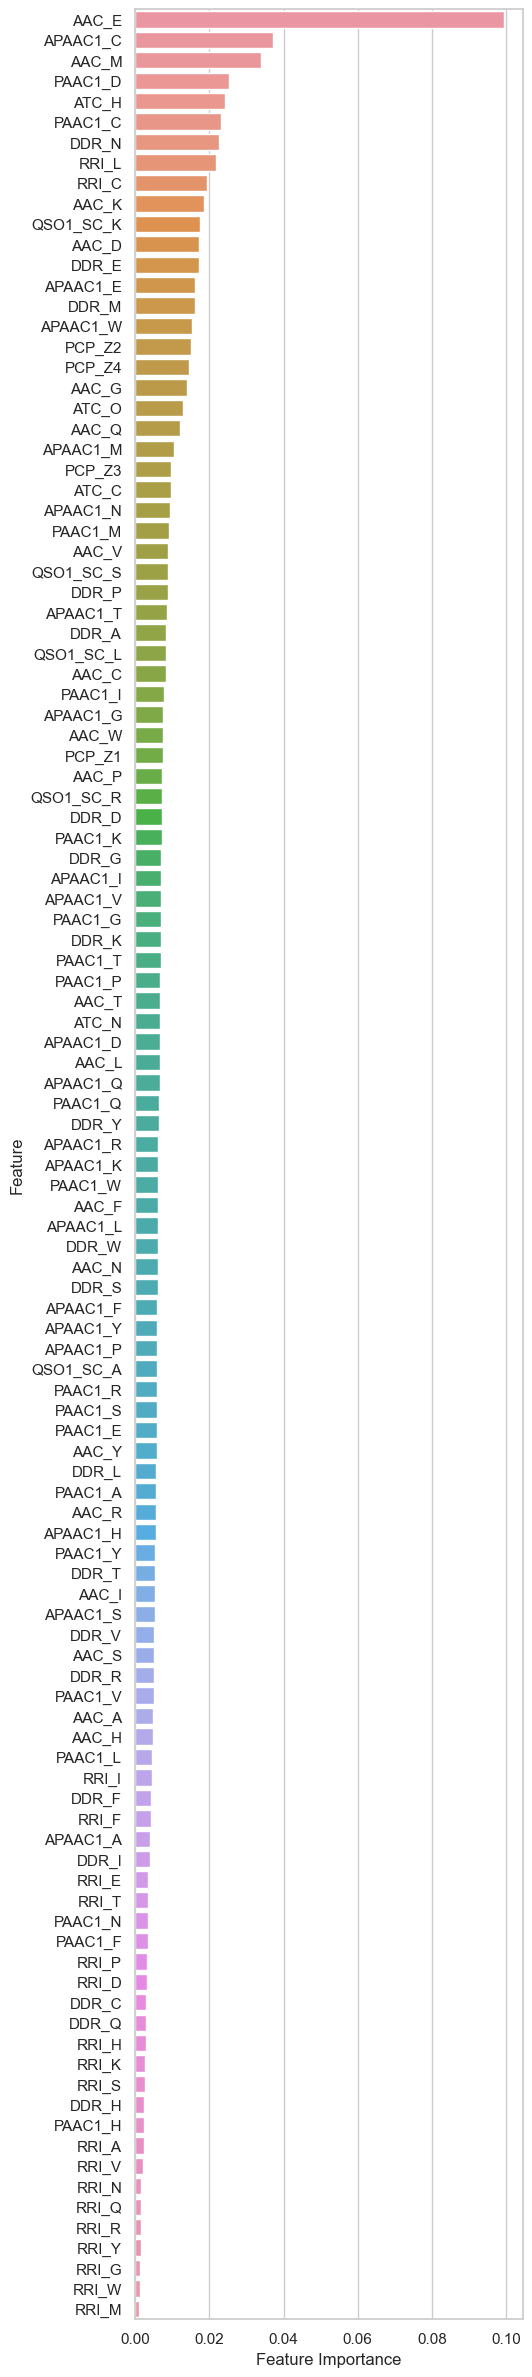

In [22]:
# Plot of feature importance
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values('Gini', ascending=False) # Sort by Gini in descending order; Showing only the top 20 results

plt.figure(figsize=(5, 30))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'Gini', y = 'Feature', data = df_sorted)
plt.xlabel("Feature Importance")

<Axes: >

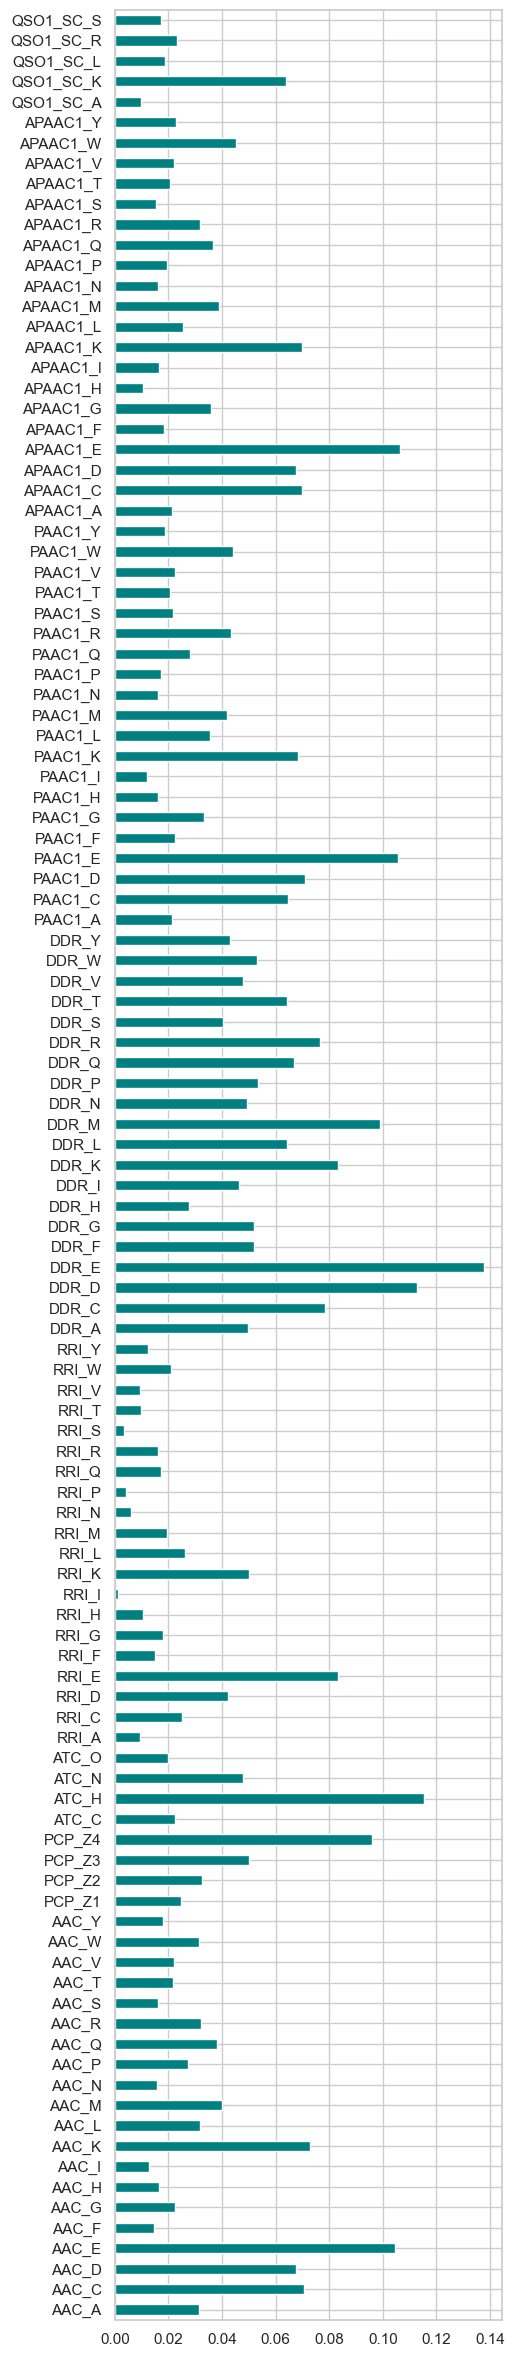

In [23]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(5, 30))
importances = mutual_info_classif(X_train, y_train)
feat_importances = pd.Series(importances, X_train.columns[0:len(X_train.columns)])
feat_importances.plot(kind='barh', color='teal')